<a href="https://colab.research.google.com/github/Ashu-00/AutoEncodersAndGenerators/blob/main/AutoEncoders(Denoise).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [ ]:
dataset=torchvision.datasets.MNIST('data',train=True,download=True,transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16302857.90it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 476467.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4364362.74it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3050036.63it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
generator1 = torch.Generator().manual_seed(42)
trainset,testset=torch.utils.data.random_split(dataset,[0.9,0.1],generator=generator1)

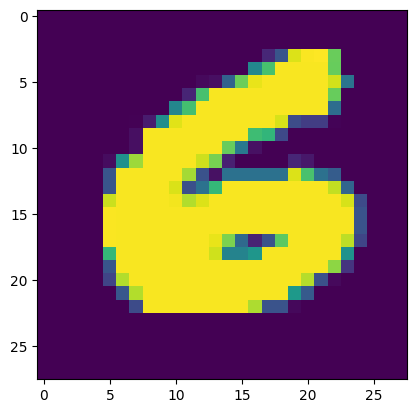

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainset[0][0].squeeze(0))

In [ ]:
class VannilaAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Conv2d(1,8,3,stride=1),
        nn.ReLU(),
        nn.Conv2d(8,16,5,stride=1),
        nn.ReLU(),
        nn.Conv2d(16,32,5,stride=2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(32,16,3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8,1,8, stride=1),
            nn.Sigmoid(),
    )
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x



In [ ]:
def noiseAdder(image,nfactor=0.25):
  noise=torch.randn_like(image) * nfactor
  return image+noise

In [ ]:
def trainwithnoise(model,train_loader,epochs=3,lr=9e-3,device="cpu"):
  model.train()
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr)
  lossfunc=nn.BCELoss()
  lossavg=0

  for epoch in range(epochs):
    for (bid,(inp,lab)) in enumerate(train_loader):
      inpnoise=noiseAdder(inp).to(device)
      optimizer.zero_grad()
      #lab=lab.to(device)
      out=model(inpnoise)
      loss=lossfunc(out,inp)
      loss.backward()
      optimizer.step()
      lossavg+=loss.item()
      if bid%50==0:
        print(f"epoch:{epoch} batch={bid} loss:{loss.item()}")

    print(f"epoch:{epoch} loss:{lossavg/((epoch+1) * len(train_loader))}")


In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)

In [ ]:
modelfordenoising=VannilaAE()
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
trainwithnoise(modelfordenoising,trainloader,epochs=5,device=device)

epoch:0 batch=0 loss:0.7358649969100952
epoch:0 batch=50 loss:0.2417089343070984
epoch:0 batch=100 loss:0.16930314898490906
epoch:0 batch=150 loss:0.1466463804244995
epoch:0 batch=200 loss:0.12323737889528275
epoch:0 batch=250 loss:0.11462739109992981
epoch:0 batch=300 loss:0.10843781381845474
epoch:0 batch=350 loss:0.10646756738424301
epoch:0 batch=400 loss:0.10393084585666656
epoch:0 loss:0.15946507144948882
epoch:1 batch=0 loss:0.10228163003921509
epoch:1 batch=50 loss:0.09843339771032333
epoch:1 batch=100 loss:0.09977041184902191
epoch:1 batch=150 loss:0.0959823727607727
epoch:1 batch=200 loss:0.09341320395469666
epoch:1 batch=250 loss:0.0957210585474968
epoch:1 batch=300 loss:0.09062308073043823
epoch:1 batch=350 loss:0.09475571662187576
epoch:1 batch=400 loss:0.08954232186079025
epoch:1 loss:0.12759335640094008
epoch:2 batch=0 loss:0.09275294095277786
epoch:2 batch=50 loss:0.0894218161702156
epoch:2 batch=100 loss:0.08842363208532333
epoch:2 batch=150 loss:0.08932246267795563
epo

In [ ]:
torch.save(modelfordenoising.state_dict(),'modelforAEdenoising.pth')

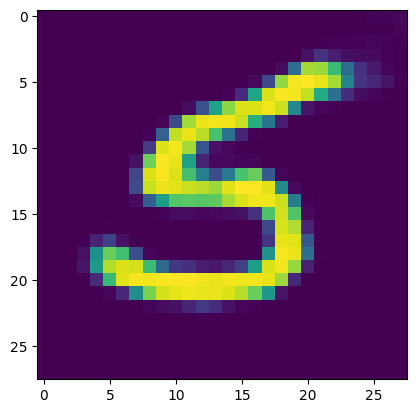

In [ ]:
#test1

img=testset[9][0].to(device).unsqueeze(0)
out=modelfordenoising(img)
plt.imshow(out.detach().cpu().squeeze(0)[0,:,:])


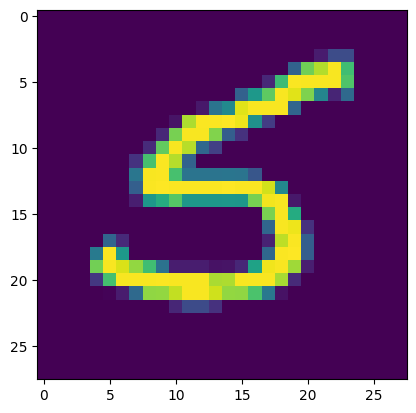

In [ ]:
plt.imshow(img.detach().cpu().squeeze(0,1))

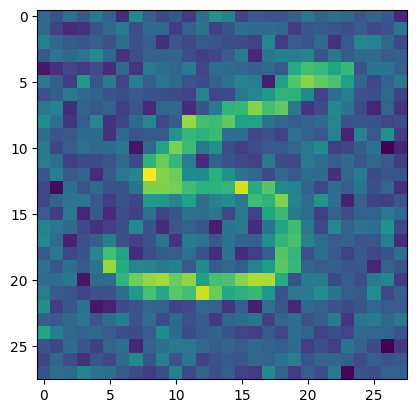

In [ ]:
plt.imshow(noiseAdder(img).detach().cpu().squeeze(0,1))

In [ ]:
def test(model,test_loader,device="cpu"):
  model.eval()
  model.to(device)
  lossfunc=nn.BCELoss()
  lossavg=0

  for (bid,(inp,lab)) in enumerate(test_loader):
      inp=inp.to(device)

      #lab=lab.to(device)
      out=model(inp)
      loss=lossfunc(out,inp)
      lossavg+=loss.item()

      print(f"batch={bid} loss:{loss.item()}")

  print(f"loss Average:{lossavg/len(test_loader)}")

In [ ]:
testloader=torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

In [ ]:
test(modelfordenoising,testloader,device=device)

batch=0 loss:0.07897648215293884
batch=1 loss:0.08156705647706985
batch=2 loss:0.08149605244398117
batch=3 loss:0.07886667549610138
batch=4 loss:0.07812327891588211
batch=5 loss:0.07698731869459152
batch=6 loss:0.08353093266487122
batch=7 loss:0.0779489204287529
batch=8 loss:0.08157207071781158
batch=9 loss:0.08255922794342041
batch=10 loss:0.07725733518600464
batch=11 loss:0.07934218645095825
batch=12 loss:0.08061002939939499
batch=13 loss:0.08183034509420395
batch=14 loss:0.08271840959787369
batch=15 loss:0.08191470056772232
batch=16 loss:0.08040232211351395
batch=17 loss:0.07656125724315643
batch=18 loss:0.08024904876947403
batch=19 loss:0.08420642465353012
batch=20 loss:0.07910696417093277
batch=21 loss:0.07929929345846176
batch=22 loss:0.07749901711940765
batch=23 loss:0.0793386697769165
batch=24 loss:0.08047172427177429
batch=25 loss:0.0760064646601677
batch=26 loss:0.07889101654291153
batch=27 loss:0.07983963936567307
batch=28 loss:0.07807105779647827
batch=29 loss:0.08030199259